#### Estimate the age of a person from the image. 

Оценить возраст человека по изображению. 
https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 

#### Exploratory and preprocessing data

Cоздать датафрейм содержащий относительный путь к изображению и целевую метку, который потом использовать при обучении.
Create a dataframe containing the relative path to the image and the target label, which is then used in training.

In [2]:
import os
import sys
import wget
import shutil
import tarfile

import re
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, MultiHeadAttention
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard


import warnings
warnings.filterwarnings('ignore')

DATA_URL = 'https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar'
DATA_FILE = 'wiki_crop.tar'
DATA_FOLDER = 'wiki_crop'

print('OpenCV version ' + cv2.__version__)

OpenCV version 4.8.0


Загрузим файл с данными по ссылке (если файл не найден на диске)

In [2]:
def bar_custom(current, total, width=80):
    progress_msg = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write('\r' + progress_msg)
    sys.stdout.flush()

if not os.path.exists(DATA_FILE):
    wget.download(DATA_URL, DATA_FILE, bar=bar_custom)

Распакуем архив с набором данных в текущий каталог,
если каталог с данными еще не существует.

In [3]:
if not os.path.exists(DATA_FOLDER):
    tar = tarfile.open(DATA_FILE, 'r')
    tar.extractall()
    tar.close()

Выполним загрузку, проверку и обработку набора изображений из файлов

In [4]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Набор обработаных изображений для оценки возраста
cropped_images = pd.DataFrame(columns=['file_path', 'label'])

# Удалить каталог со старыми обработанными изображеним если существует, если нет - создать
if os.path.exists(os.path.join(DATA_FOLDER, 'cropped')):
    shutil.rmtree(os.path.join(DATA_FOLDER, 'cropped'), ignore_errors=True)

os.makedirs(os.path.join(DATA_FOLDER, 'cropped'))

IMG_SIZE = 64

img_valid=0 #счетчик всех корректных изображений
img_misloaded=0 #счетчик изображений с ошибками при загрузке
img_too_small=0 #счетчик изображений некорректного размера (1х1)
img_bad_faces=0 #счетчик изображений без лиц
img_bad_label=0 #счетчик изображений с некорретной оценкой класса

# Перебор всех вложенных элементов в указаном каталоге
for dir in tqdm(os.listdir(DATA_FOLDER)):
    # если вложенный элемент - каталог
    if os.path.isdir(os.path.join(DATA_FOLDER, dir)):
        # Перебор всех файлов в каталоге
        for file in os.listdir(os.path.join(DATA_FOLDER, dir)):
            try:
                source_file_path = os.path.join(DATA_FOLDER, dir, file)

                # загрузить изображение и сконвертировать в монохромное
                img = Image.open(source_file_path).convert('L')
                img_array = np.array(img)

                # получить параметры изображения
                h, w = img_array.shape[:2]

                # если размер изображения меньше заданного - пропускаем
                if w < 128:
                    img_too_small+=1 
                    continue

                # выполняем детекцию лиц с максимально строгими настройками и минимальным размером лица 64х64
                face_rects1 = face_detector.detectMultiScale(img_array, scaleFactor=1.3, minNeighbors=6, minSize=(64,64))

                # оставляем только фото на которых есть только 1 лицо, остальные - пропускаем
                if len(face_rects1) != 1:
                    img_bad_faces+=1
                    continue  

               
    
                # формируем целевую метку изображения, как разность между вторым и первым годами в наименовании файла
                year_matched = re.findall(r'_(\d{4})', file)
                try:
                    label = int(year_matched[1]) - int(year_matched[0])
                except:
                    label = -1 
                
                # оставляем только изображения к меткой из заданного диапазона
                if (label < 1) | (label > 100):
                    img_bad_label+=1
                    continue

                # выполняем обрезку изображения по контуру лица и приведение к требуемому размеру
                x,y,h,w = face_rects1[0]
                img = img.crop((x, y, x+w, y+h)).resize((IMG_SIZE,IMG_SIZE), resample=Image.Resampling.BILINEAR)    

                # сохраняем обрезанное изображение в файл
                cropped_file_path = os.path.join(DATA_FOLDER, 'cropped', file)
                cropped_images = pd.concat([cropped_images, pd.DataFrame([{'file_path': cropped_file_path, 'label': label}])], ignore_index=True)
                img.save(cropped_file_path)
                
                
            except Exception as ex:
                img_misloaded+=1
                None # Если файл не удается прочитать - пропускаем его

print(f'Изображений с ошибками при загрузке {img_misloaded}')
print(f'Изображений с некорректными размерами {img_too_small}')
print(f'Изображений на которых не найдены лица {img_bad_faces}')
print(f'Изображений c некорректной меткой класса {img_bad_label}')

print(f'Всего корректных изображений {cropped_images.shape[0]}')

# Сохранить результат обработки данных в CSV-файл
cropped_images.to_csv('imdb_crops_3.csv')

100%|██████████| 103/103 [02:04<00:00,  1.20s/it]

Изображений с ошибками при загрузке 0
Изображений с некорректными размерами 35479
Изображений на которых не найдены лица 22110
Изображений c некорректной меткой класса 25
Всего корректных изображений 23667


In [2]:
cropped_images_full = pd.read_csv('imdb_crops_3.csv')
cropped_images_full.drop(['Unnamed: 0'], axis=1, inplace=True)
cropped_images_full.head(3)

,file_path,label
0,wiki_crop/cropped/2399661_1977-09-02_2008.jpg,31
1,wiki_crop/cropped/44438061_1937-11-14_1969.jpg,32
2,wiki_crop/cropped/37699961_1890-12-11_1947.jpg,57


Отобразим произвольные 50 файлов изображений из набора обработанных данных. 

Display arbitrary 50 image files from the processed dataset.

<Axes: >

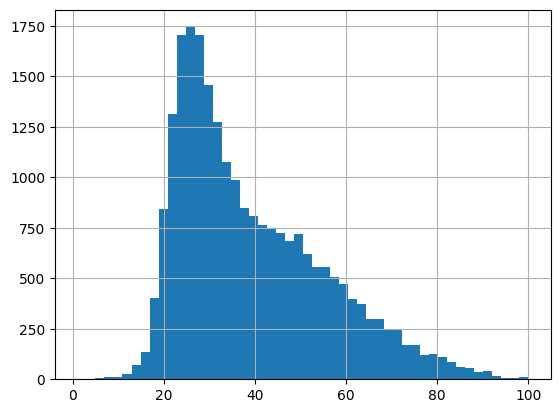

In [3]:
cropped_images_full['label'].hist(bins=50)

In [4]:
cropped_images = cropped_images_full[(cropped_images_full['label'] >= 18) & (cropped_images_full['label'] <= 60)]

<Axes: >

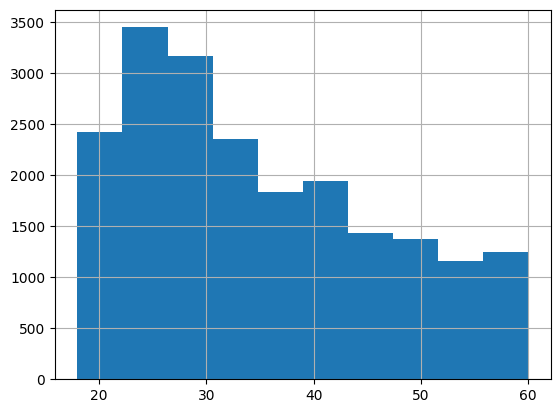

In [5]:
cropped_images['label'].hist()

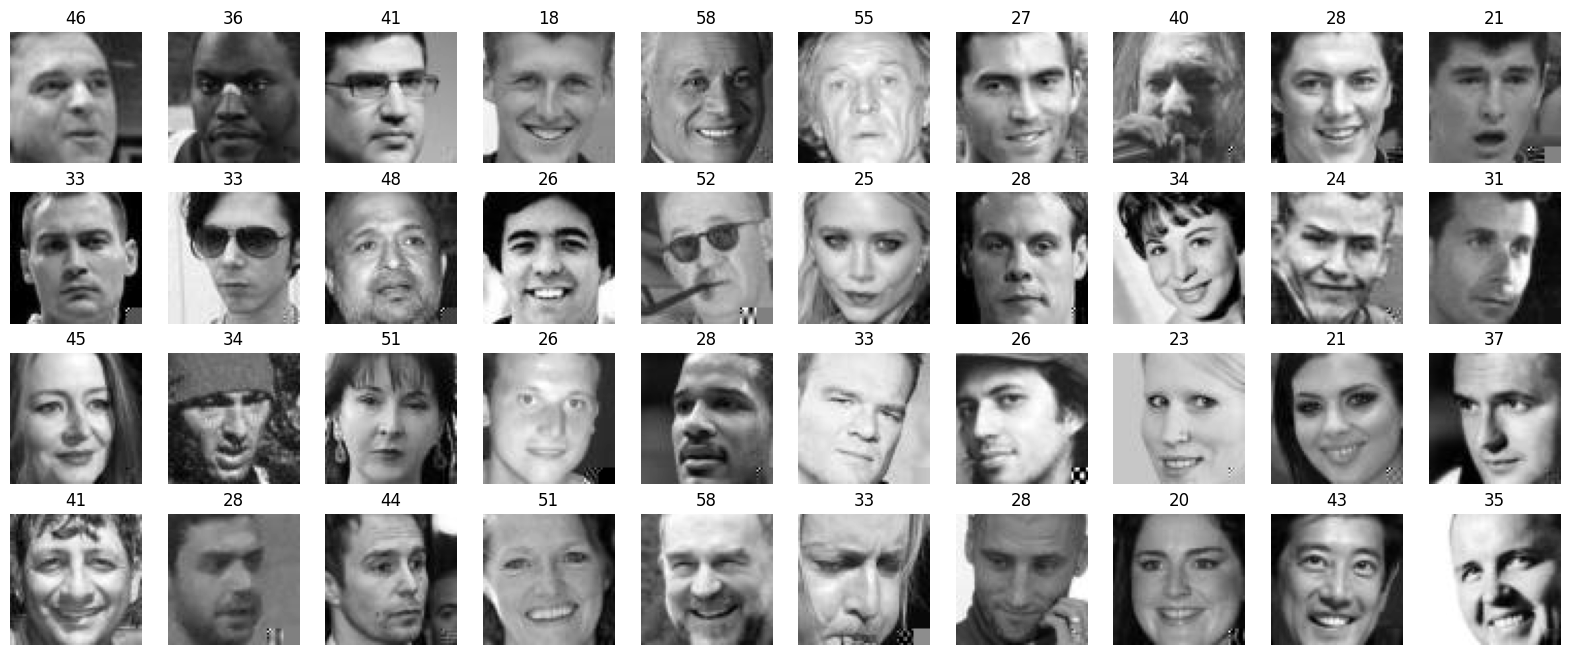

In [8]:
df = cropped_images
fig, ax = plt.subplots(4, 10, figsize=(20, 8))

for i in range(4):
    for j in range(10):
        idx = np.random.choice(range(df.shape[0]))
        file, label = df.iloc[idx].file_path, df.iloc[idx].label
        ax[i, j].imshow(plt.imread(file), cmap='gray')
        ax[i, j].set_title(label)
        ax[i, j].axis('off')

---

#### Split the data using ImageDataGenerator

Разобьем данные на train, validation, test с помощью ImageDataGenerator. 

Split the data into train, validation, test using ImageDataGenerator

In [6]:
cropped_images['label'] = cropped_images['label'].astype(np.int32)

In [7]:
train, test = train_test_split(cropped_images, test_size=0.1, random_state=42)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.1)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [9]:
TARGET_SIZE = (64,64)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='grayscale',
target_size=TARGET_SIZE)

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='grayscale',
target_size=TARGET_SIZE)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="file_path",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='grayscale',
target_size=TARGET_SIZE)



Found 16512 validated image filenames.
Found 1834 validated image filenames.
Found 2039 validated image filenames.


----------------

#### Create a model and train it.

Создадим две модели регрессии, одну без MHA и вторую с MHA и обучим их. 

Create two regression models, one without MHA and the other with MHA, and train them.

In [25]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1), padding="same"),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding="same", activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), padding="same", activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(1024, (3, 3), padding="same", activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='relu')  # Регрессионный выход
])

# Компиляция модели
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])



In [26]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 dropout_44 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 dropout_45 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                

In [27]:
# Обучение модели
history = model.fit_generator(train_generator, epochs=30, validation_data= valid_generator)

Epoch 1/30


2023-09-25 20:08:27.058992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


516/516 [==============================] - ETA: 0s - loss: 189.4560 - mae: 10.8595

2023-09-25 20:08:47.906216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


516/516 [==============================] - 22s 41ms/step - loss: 189.4560 - mae: 10.8595 - val_loss: 352.7971 - val_mae: 15.0178
Epoch 2/30
516/516 [==============================] - 21s 41ms/step - loss: 127.8381 - mae: 9.4390 - val_loss: 291.2376 - val_mae: 13.1712
Epoch 3/30
516/516 [==============================] - 21s 40ms/step - loss: 121.8233 - mae: 9.1780 - val_loss: 298.6286 - val_mae: 13.6747
Epoch 4/30
516/516 [==============================] - 21s 40ms/step - loss: 113.7895 - mae: 8.7700 - val_loss: 265.0073 - val_mae: 12.5492
Epoch 5/30
516/516 [==============================] - 22s 43ms/step - loss: 107.4493 - mae: 8.4597 - val_loss: 269.1138 - val_mae: 13.1449
Epoch 6/30
516/516 [==============================] - 30s 59ms/step - loss: 101.6299 - mae: 8.1820 - val_loss: 229.1068 - val_mae: 11.7053
Epoch 7/30
516/516 [==============================] - 39s 76ms/step - loss: 96.1104 - mae: 7.9136 - val_loss: 197.2007 - val_mae: 10.6616
Epoch 8/30
516/516 [==================

<Axes: >

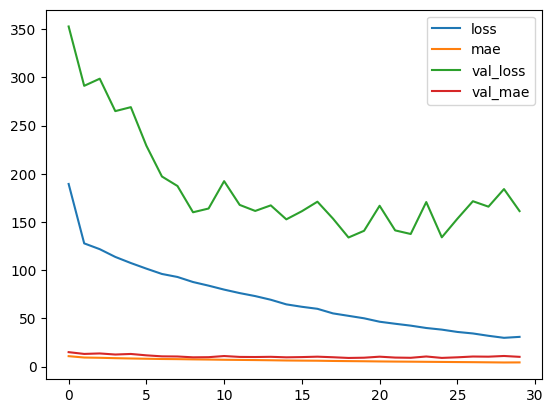

In [28]:
#loss='mean_squared_error', metrics=['mae']
pd.DataFrame(history.history).plot()

#### Create a model with Multi-head Attention and train it.

In [3]:
# Define the input shape
input_shape = (64, 64, 1)

# Input layer
input_layer = layers.Input(shape=input_shape)

# Convolutional layers
x = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(input_layer)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), padding="same", activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), padding="same", activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(512, (3, 3), padding="same", activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(1024, (3, 3), padding="same", activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten and apply Dense layers
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# MultiHeadAttention layer
attention_output = layers.MultiHeadAttention(num_heads=8, key_dim=512, attention_axes=(0, 1))(x, x)

x = layers.Dropout(0.2)(attention_output)
output = layers.Dense(1, activation='relu')(x)

# Create the model
model_MHA = models.Model(inputs=input_layer, outputs=output)

# Compile the model
model_MHA.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display model summary
model_MHA.summary()



2023-10-04 15:11:07.938610: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-10-04 15:11:07.938631: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-04 15:11:07.938636: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-04 15:11:07.938691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-04 15:11:07.938722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           320       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 64, 64, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)           0         ['dropout[0][0]']             
 D)                                                                                           

In [34]:
history = model_MHA.fit_generator(train_generator, epochs=20, validation_data= valid_generator)

Epoch 1/20


2023-10-03 16:42:40.337791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


515/516 [============================>.] - ETA: 0s - loss: 184.0723 - mae: 10.7754

2023-10-03 16:43:06.429586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


516/516 [==============================] - 28s 52ms/step - loss: 183.9368 - mae: 10.7725 - val_loss: 358.3470 - val_mae: 15.1201
Epoch 2/20
516/516 [==============================] - 26s 50ms/step - loss: 132.5889 - mae: 9.7110 - val_loss: 268.0644 - val_mae: 12.2800
Epoch 3/20
516/516 [==============================] - 26s 50ms/step - loss: 144.3063 - mae: 10.0144 - val_loss: 148.4701 - val_mae: 9.5268
Epoch 4/20
516/516 [==============================] - 26s 50ms/step - loss: 131.0910 - mae: 9.6996 - val_loss: 132.1281 - val_mae: 9.6389
Epoch 5/20
516/516 [==============================] - 26s 50ms/step - loss: 130.9259 - mae: 9.7119 - val_loss: 154.6792 - val_mae: 9.5845
Epoch 6/20
516/516 [==============================] - 26s 50ms/step - loss: 130.6206 - mae: 9.6769 - val_loss: 132.1938 - val_mae: 9.6322
Epoch 7/20
516/516 [==============================] - 26s 50ms/step - loss: 131.1082 - mae: 9.6995 - val_loss: 146.2102 - val_mae: 9.5032
Epoch 8/20
516/516 [=====================

<Axes: >

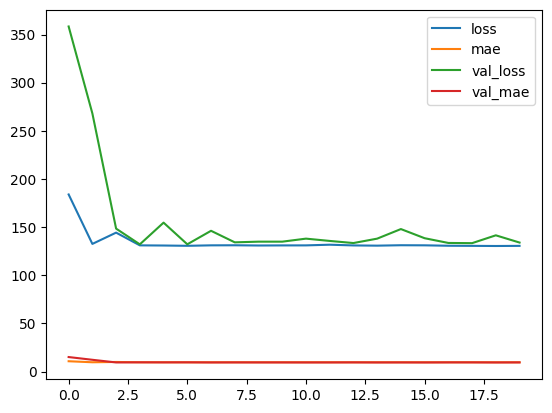

In [35]:
pd.DataFrame(history.history).plot()

### Выводы: 

Обработав данные и выделив из картинок только те что были с лицами в монохроме, нужного размера 64/64, и корректной меткой класса. Я обучила две модели: одна нейронная модель и вторая с Multi-head Attention. Однако по графикам видно, что не растет точность и ошибка на валидационной выборке не коррелирует с тестовой.

After processing the data and extracting only the monochrome images with faces of the required size of 64/64 and correct class labels, I trained two models: one neural model and the other with Multi-head Attention. However, from the plots, it can be seen that the accuracy is not improving, and the error on the validation set does not correlate with the test set.